Graph is connected


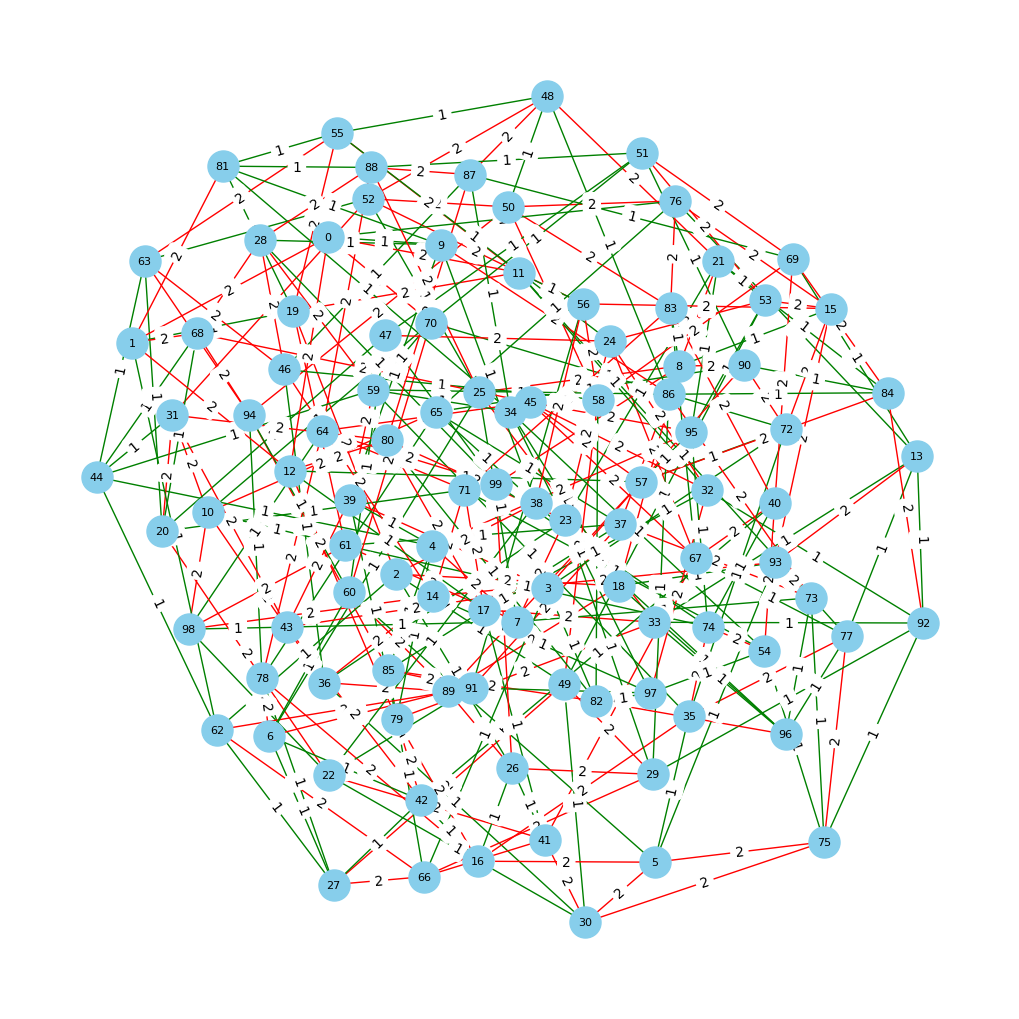

In [34]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Parameters
n_nodes = 100  # Number of nodes
degree = 6     # Connectivity degree

# Generate a random regular graph
G = nx.random_regular_graph(degree, n_nodes)

# Assign weights to the edges
# Weight 2 for congested roads, weight 1 for non-congested roads
for u, v in G.edges():
    # Randomly assign weights: 1 (non-congested) or 2 (congested)
    G[u][v]['weight'] = random.choice([1, 2])

# Check if the graph is connected
if nx.is_connected(G):
    print("Graph is connected")
else:
    print("Graph is not connected")

# Draw the graph with weighted edges
edge_colors = ['red' if G[u][v]['weight'] == 2 else 'green' for u, v in G.edges()]
pos = nx.spring_layout(G)  # Position nodes for better visualization

plt.figure(figsize=(10, 10))
nx.draw(G, pos, node_color='skyblue', with_labels=True, node_size=500, font_size=8, edge_color=edge_colors)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()


In [35]:
nx.is_connected(G)      # check whether G which has at least one path between each pair of nodes.

True

In [83]:
import networkx as nx
import random
from collections import deque

# Global waiting list
waiting_list = []

# Define the vehicle and customer classes
class Vehicle:
    def __init__(self, vehicle_id):
        self.id = vehicle_id
        self.queue = deque()  # List of customers in the vehicle (FIFO)
        self.path = []        # Route the vehicle is taking
        self.current_node = None  # Current position of the vehicle
        self.completed_customers = []  # Store customers who have been picked up and dropped off

    def add_customer(self, customer):
        self.queue.append(customer)

class Customer:
    def __init__(self, pickup, dropoff, request_time):
        self.pickup = pickup
        self.dropoff = dropoff
        self.request_time = request_time
        self.pickup_time = None
        self.dropoff_time = None

# Generate a random customer request
def generate_reservation(time):
    pickup = random.randint(0, 99)  # Random pickup node
    dropoff = random.randint(0, 99)  # Random dropoff node
    while dropoff == pickup:
        dropoff = random.randint(0, 99)  # Ensure dropoff is different
    return Customer(pickup, dropoff, time)

# Assign a customer to an available vehicle
def assign_vehicle(customer, vehicles):
    # Find the first available vehicle (that is not full)
    for vehicle in vehicles:
        if len(vehicle.queue) < 5:  # Assuming the vehicle can hold 5 customers
            vehicle.add_customer(customer)
            return
    # If no vehicle is available, add the customer to a waiting list
    print(f"No available vehicles for customer at time {customer.request_time}, added to waiting list")
    waiting_list.append(customer)

# Process the waiting list and assign customers to vehicles
def process_waiting_list(vehicles):
    global waiting_list  # Access the global waiting list
    for customer in waiting_list[:]:  # Copy the list to modify it during iteration
        for vehicle in vehicles:
            if len(vehicle.queue) < 5:  # Check if the vehicle has space
                vehicle.add_customer(customer)
                waiting_list.remove(customer)
                break  # Assign one customer at a time to available vehicles

# Process vehicle movement and drop off customers
def process_vehicle_movement(vehicle, clock):
    # Ensure vehicle's path is initialized as a list
    if vehicle.path is None:
        vehicle.path = []

    # Check if the vehicle has a customer and no path
    if not vehicle.path and vehicle.queue:
        next_customer = vehicle.queue[0]
        # If this is the first time the customer is being picked up, record pickup time
        if next_customer.pickup_time is None:
            next_customer.pickup_time = clock
            print(f"Customer picked up at time {clock} by Vehicle {vehicle.id}")

        # Calculate the shortest path to the customer's dropoff location
        try:
            vehicle.path = nx.shortest_path(G, vehicle.current_node, next_customer.dropoff, weight='weight')
            if isinstance(vehicle.path, list):
                print(f"Vehicle {vehicle.id} moving along path: {vehicle.path}")
            else:
                print(f"Error: Expected a list, but got {type(vehicle.path)}. Path: {vehicle.path}")
        except nx.NetworkXNoPath:
            print(f"No path found for vehicle {vehicle.id} to customer {next_customer.dropoff}")
            return  # If no path is found, stop processing for this tick

    # If the path is still empty (no valid path), do nothing
    if not vehicle.path:
        print(f"Vehicle {vehicle.id} has no path at clock {clock}")
        return

    # Move along the path one step
    next_node = vehicle.path.pop(0)  # Safely pop the next node from the list
    vehicle.current_node = next_node

    # Check if any customer needs to be dropped off at this node
    for customer in list(vehicle.queue):
        if customer.dropoff == vehicle.current_node:
            print(f"Dropping off customer at {vehicle.current_node} at time {clock}")
            vehicle.queue.remove(customer)
            customer.dropoff_time = clock  # Record the dropoff time
            vehicle.completed_customers.append(customer)  # Track completed customers

# Simulate a day of operations without Vehicle 0
def simulate_day():
    clock = 0
    # Exclude Vehicle 0 by starting the list from Vehicle 1 (ID 1 to 29)
    vehicles = [Vehicle(i) for i in range(1, 30)]
    total_reservations = random.randint(450, 600) * 10
    global G
    G = nx.random_regular_graph(6, 100)  # Generate a random regular graph with 100 nodes and degree 6

    # Assign weights (1 or 2) to the edges to simulate congestion
    for (u, v) in G.edges():
        G.edges[u, v]['weight'] = random.choice([1, 2])

    # Start the simulation from 8 AM to 6 PM (10 hours)
    while clock < 10 * 60 or any(vehicle.queue for vehicle in vehicles) or waiting_list:
        if clock < 10 * 60:  # During service hours
            for _ in range(total_reservations // 600):  # Generate reservations each minute
                customer = generate_reservation(clock)
                assign_vehicle(customer, vehicles)

        # Process waiting list
        process_waiting_list(vehicles)

        # Move vehicles and process customer drop-offs
        for vehicle in vehicles:
            if vehicle.queue:
                if vehicle.current_node is None:  # Assign a random starting node if not set
                    vehicle.current_node = random.randint(0, 99)
                process_vehicle_movement(vehicle, clock)

            # Display service queues (S) and routing queues (P)
            service_queue = [(c.pickup, c.dropoff) for c in vehicle.queue]  # Pickup and dropoff points
            print(f"Clock {clock}: Vehicle {vehicle.id} Service Queue (S): {service_queue}")
            print(f"Clock {clock}: Vehicle {vehicle.id} Routing Path (P): {vehicle.path}")

        clock += 1  # Increment clock

    return vehicles

# Compute performance metrics
def compute_metrics(vehicles):
    total_waiting_time = 0
    total_service_time = 0
    total_trips = 0

    # Iterate over all completed customers across vehicles
    for vehicle in vehicles:
        for customer in vehicle.completed_customers:
            # Ensure both pickup and dropoff times are recorded before calculating
            if customer.pickup_time is not None and customer.dropoff_time is not None:
                total_waiting_time += customer.pickup_time - customer.request_time
                total_service_time += customer.dropoff_time - customer.pickup_time
                total_trips += 1

    avg_waiting_time = total_waiting_time / total_trips if total_trips > 0 else 0
    avg_service_time = total_service_time / total_trips if total_trips > 0 else 0
    avg_trips = total_trips / len(vehicles) if len(vehicles) > 0 else 0

    return avg_waiting_time, avg_service_time, avg_trips

# Step 1: Run the simulation (without Vehicle 0)
vehicles = simulate_day()  # This now excludes Vehicle 0 (starts from Vehicle 1)

# Step 2: Calculate metrics
avg_waiting_time, avg_service_time, avg_trips = compute_metrics(vehicles)

# Step 3: Output the results
print(f"Average Waiting Time: {avg_waiting_time}")
print(f"Average Service Time: {avg_service_time}")
print(f"Average Trips per Day: {avg_trips}")


Streaming output truncated to the last 5000 lines.
Clock 602: Vehicle 26 Routing Path (P): [6, 83, 7, 70]
Customer picked up at time 602 by Vehicle 27
Vehicle 27 moving along path: [97, 57]
Clock 602: Vehicle 27 Service Queue (S): [(23, 57), (79, 87), (2, 27), (3, 88), (83, 70)]
Clock 602: Vehicle 27 Routing Path (P): [57]
Customer picked up at time 602 by Vehicle 28
Vehicle 28 moving along path: [0, 88, 6, 87]
Clock 602: Vehicle 28 Service Queue (S): [(95, 87), (2, 19), (3, 98), (98, 3), (37, 81)]
Clock 602: Vehicle 28 Routing Path (P): [88, 6, 87]
Customer picked up at time 602 by Vehicle 29
Vehicle 29 moving along path: [9, 41, 43]
Clock 602: Vehicle 29 Service Queue (S): [(13, 43), (53, 19), (97, 50), (28, 80), (81, 66)]
Clock 602: Vehicle 29 Routing Path (P): [41, 43]
Clock 603: Vehicle 1 Service Queue (S): [(92, 44), (28, 13), (6, 83), (53, 85), (84, 75)]
Clock 603: Vehicle 1 Routing Path (P): [94, 44]
Customer picked up at time 603 by Vehicle 2
Vehicle 2 moving along path: [71, 

In [84]:
import networkx as nx
import random
from collections import deque

# Global waiting list
waiting_list = []

# Define the vehicle and customer classes
class Vehicle:
    def __init__(self, vehicle_id):
        self.id = vehicle_id
        self.queue = deque()  # List of customers in the vehicle (FIFO)
        self.path = []        # Route the vehicle is taking
        self.current_node = None  # Current position of the vehicle
        self.completed_customers = []  # Store customers who have been picked up and dropped off

    def add_customer(self, customer):
        self.queue.append(customer)

class Customer:
    def __init__(self, pickup, dropoff, request_time):
        self.pickup = pickup
        self.dropoff = dropoff
        self.request_time = request_time
        self.pickup_time = None
        self.dropoff_time = None

# Generate a random customer request
def generate_reservation(time):
    pickup = random.randint(0, 99)  # Random pickup node
    dropoff = random.randint(0, 99)  # Random dropoff node
    while dropoff == pickup:
        dropoff = random.randint(0, 99)  # Ensure dropoff is different
    return Customer(pickup, dropoff, time)

# Assign a customer to an available vehicle
def assign_vehicle(customer, vehicles):
    # Find the first available vehicle (that is not full)
    for vehicle in vehicles:
        if len(vehicle.queue) < 5:  # Assuming the vehicle can hold 5 customers
            vehicle.add_customer(customer)
            return
    # If no vehicle is available, add the customer to a waiting list
    print(f"No available vehicles for customer at time {customer.request_time}, added to waiting list")
    waiting_list.append(customer)

# Process the waiting list and assign customers to vehicles
def process_waiting_list(vehicles):
    global waiting_list  # Access the global waiting list
    for customer in waiting_list[:]:  # Copy the list to modify it during iteration
        for vehicle in vehicles:
            if len(vehicle.queue) < 5:  # Check if the vehicle has space
                vehicle.add_customer(customer)
                waiting_list.remove(customer)
                break  # Assign one customer at a time to available vehicles

# Process vehicle movement and drop off customers
def process_vehicle_movement(vehicle, clock):
    # Ensure vehicle's path is initialized as a list
    if vehicle.path is None:
        vehicle.path = []

    # Check if the vehicle has a customer and no path
    if not vehicle.path and vehicle.queue:
        next_customer = vehicle.queue[0]
        # If this is the first time the customer is being picked up, record pickup time
        if next_customer.pickup_time is None:
            next_customer.pickup_time = clock
            print(f"Customer picked up at time {clock} by Vehicle {vehicle.id}")

        # Calculate the shortest path to the customer's dropoff location
        try:
            vehicle.path = nx.shortest_path(G, vehicle.current_node, next_customer.dropoff, weight='weight')
            if isinstance(vehicle.path, list):
                print(f"Vehicle {vehicle.id} moving along path: {vehicle.path}")
            else:
                print(f"Error: Expected a list, but got {type(vehicle.path)}. Path: {vehicle.path}")
        except nx.NetworkXNoPath:
            print(f"No path found for vehicle {vehicle.id} to customer {next_customer.dropoff}")
            return  # If no path is found, stop processing for this tick

    # If the path is still empty (no valid path), do nothing
    if not vehicle.path:
        print(f"Vehicle {vehicle.id} has no path at clock {clock}")
        return

    # Move along the path one step
    next_node = vehicle.path.pop(0)  # Safely pop the next node from the list
    vehicle.current_node = next_node

    # Check if any customer needs to be dropped off at this node
    for customer in list(vehicle.queue):
        if customer.dropoff == vehicle.current_node:
            print(f"Dropping off customer at {vehicle.current_node} at time {clock}")
            vehicle.queue.remove(customer)
            customer.dropoff_time = clock  # Record the dropoff time
            vehicle.completed_customers.append(customer)  # Track completed customers

# Simulate a day of operations without Vehicle 0
def simulate_day():
    clock = 0
    # Exclude Vehicle 0 by starting the list from Vehicle 1 (ID 1 to 29)
    vehicles = [Vehicle(i) for i in range(1, 60)]
    total_reservations = random.randint(450, 600) * 10
    global G
    G = nx.random_regular_graph(6, 100)  # Generate a random regular graph with 100 nodes and degree 6

    # Assign weights (1 or 2) to the edges to simulate congestion
    for (u, v) in G.edges():
        G.edges[u, v]['weight'] = random.choice([1, 2])

    # Start the simulation from 8 AM to 6 PM (10 hours)
    while clock < 10 * 60 or any(vehicle.queue for vehicle in vehicles) or waiting_list:
        if clock < 10 * 60:  # During service hours
            for _ in range(total_reservations // 600):  # Generate reservations each minute
                customer = generate_reservation(clock)
                assign_vehicle(customer, vehicles)

        # Process waiting list
        process_waiting_list(vehicles)

        # Move vehicles and process customer drop-offs
        for vehicle in vehicles:
            if vehicle.queue:
                if vehicle.current_node is None:  # Assign a random starting node if not set
                    vehicle.current_node = random.randint(0, 99)
                process_vehicle_movement(vehicle, clock)

            # Display service queues (S) and routing queues (P)
            service_queue = [(c.pickup, c.dropoff) for c in vehicle.queue]  # Pickup and dropoff points
            print(f"Clock {clock}: Vehicle {vehicle.id} Service Queue (S): {service_queue}")
            print(f"Clock {clock}: Vehicle {vehicle.id} Routing Path (P): {vehicle.path}")

        clock += 1  # Increment clock

    return vehicles

# Compute performance metrics
def compute_metrics(vehicles):
    total_waiting_time = 0
    total_service_time = 0
    total_trips = 0

    # Iterate over all completed customers across vehicles
    for vehicle in vehicles:
        for customer in vehicle.completed_customers:
            # Ensure both pickup and dropoff times are recorded before calculating
            if customer.pickup_time is not None and customer.dropoff_time is not None:
                total_waiting_time += customer.pickup_time - customer.request_time
                total_service_time += customer.dropoff_time - customer.pickup_time
                total_trips += 1

    avg_waiting_time = total_waiting_time / total_trips if total_trips > 0 else 0
    avg_service_time = total_service_time / total_trips if total_trips > 0 else 0
    avg_trips = total_trips / len(vehicles) if len(vehicles) > 0 else 0

    return avg_waiting_time, avg_service_time, avg_trips

# Step 1: Run the simulation (without Vehicle 0)
vehicles = simulate_day()  # This now excludes Vehicle 0 (starts from Vehicle 1)

# Step 2: Calculate metrics
avg_waiting_time, avg_service_time, avg_trips = compute_metrics(vehicles)

# Step 3: Output the results
print(f"Average Waiting Time: {avg_waiting_time}")
print(f"Average Service Time: {avg_service_time}")
print(f"Average Trips per Day: {avg_trips}")


Streaming output truncated to the last 5000 lines.
Vehicle 25 moving along path: [88, 13, 5, 0, 56]
Clock 583: Vehicle 25 Service Queue (S): [(39, 56), (65, 70), (48, 95), (30, 89), (13, 56)]
Clock 583: Vehicle 25 Routing Path (P): [13, 5, 0, 56]
Dropping off customer at 16 at time 583
Clock 583: Vehicle 26 Service Queue (S): [(55, 70), (17, 81), (18, 44), (81, 97)]
Clock 583: Vehicle 26 Routing Path (P): []
Dropping off customer at 56 at time 583
Clock 583: Vehicle 27 Service Queue (S): [(71, 15), (7, 76), (19, 54), (2, 61)]
Clock 583: Vehicle 27 Routing Path (P): []
Clock 583: Vehicle 28 Service Queue (S): [(53, 58)]
Clock 583: Vehicle 28 Routing Path (P): [46, 58]
Clock 583: Vehicle 29 Service Queue (S): []
Clock 583: Vehicle 29 Routing Path (P): []
Clock 583: Vehicle 30 Service Queue (S): []
Clock 583: Vehicle 30 Routing Path (P): []
Clock 583: Vehicle 31 Service Queue (S): []
Clock 583: Vehicle 31 Routing Path (P): []
Clock 583: Vehicle 32 Service Queue (S): []
Clock 583: Vehicle 